# 数据准备

In [2]:
import os  
import torch  
import pandas as pd  
import matplotlib.pyplot as plt
  
    #step1:加载数据集
# 设置数据集的路径  
data_dir = '../../DataFiles/ODS/strain'   
# 创建空的列表来存储所有的DataFrame  
X_data0 = []  
y_data0 = []
# 遍历指定目录下的所有文件  
for filename in os.listdir(data_dir):  
    if filename.endswith('.csv'):  
        # 构建文件的完整路径  
        file_path = os.path.join(data_dir, filename)  
        # 读取Excel文件  
        df = pd.read_csv(file_path)
        serie=df.iloc[:, 0]
        version_without_extension = filename.rsplit(".", 1)[0] 
        serie.name=version_without_extension
        # 将读取的DataFrame添加到列表中  
        X_data0.append(serie)
        y_data0.append(version_without_extension)

    #step2:遍历X_data0中的每个DataFrame，并删除非数字数据  
cleaned_data = []  
for df in X_data0:  
    df_cleaned = df[pd.to_numeric(df, errors='coerce').notnull()]  
    cleaned_data.append(df_cleaned)  
 

    #step3:将X_data0中的每个DataFrame的所有元素变为float类型 
for i, df in enumerate(cleaned_data):  
    X_data0[i] = df.astype(float) 

# 初始化X_data1来存储结果  
X_data1 = []  
  
# 遍历X_data0中的每个Series  
for series in X_data0:  
    # 计算步长（由于重叠率为50%，步长为序列长度的一半）  
    step_size = 1024  # 因为2048的一半是1024，且我们想要50%的重叠  
    # 初始化一个空的list来存储子序列  
    subsequences = []  
    # 使用range和步长来生成子序列  
    for i in range(0, len(series) - 2048+ 1, step_size):  
        # 确保切片是一维的，并转换为Series（虽然这里切片已经是Series）  
        subsequence = series.iloc[i:i+2048]  
        subsequences.append(subsequence) 
    X_data1.append(subsequences)  
print((type(X_data1),len(X_data1),len(X_data1[0])))

import pandas as pd  
import numpy as np  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder  
from keras.utils import to_categorical
import time  
from keras.callbacks import Callback  
import torch 

# 假设 X_data1 已经定义好了  
all_data = []  
all_labels = []  
  
for sublist in X_data1:  
    for series in sublist:  
        # 假设每个series是pandas Series  
        all_data.append(series.values)  
        all_labels.append(series.name)  
  
# 将数据转换为numpy数组  
data_array = np.array(all_data)  
# 将标签转换为编码  

label_encoder = LabelEncoder()  
labels_encoded = label_encoder.fit_transform(all_labels)  
  
# 如果需要one-hot编码  
labels_one_hot = to_categorical(labels_encoded)  
  
# 这里你可能需要reshape data_array 以符合LSTM的输入要求  
# LSTM通常要求输入形状为 (samples, time_steps, features)  
# 假设每个series的长度相同，或者你可以填充/截断它们以具有相同的长度  
# time_steps = data_array.shape[1]  # 假设所有series长度相同  
# data_array = data_array.reshape(-1, time_steps, 1)  # 增加一个维度以匹配LSTM的输入要求

# 分割数据集  
X_train, X_temp, y_train, y_temp = train_test_split(data_array, labels_one_hot, test_size=0.3, random_state=42)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print((type(X_train),X_train.shape,type(y_train),y_train.shape))
X_train_first_12 = X_train[:12]  

(<class 'list'>, 2, 1814)
(<class 'numpy.ndarray'>, (2412, 2048), <class 'numpy.ndarray'>, (2412, 2))


# VMD的实现和效果展示
- 我的个人理解：[VMD](https://github.com/RosenKreutzs/ClassifyBearing/blob/master/LSTM/EXPLAINATION_VMD.md)；

## step1:对原始信号进行VMD操作，获得IMF组；

[1.14397657e-07 6.14383067e-02 1.57475886e-01 3.09580122e-01
 4.42706764e-01]


C:\Users\chell\anaconda3\envs\110SPMEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chell\anaconda3\envs\110SPMEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chell\anaconda3\envs\110SPMEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chell\anaconda3\envs\110SPMEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


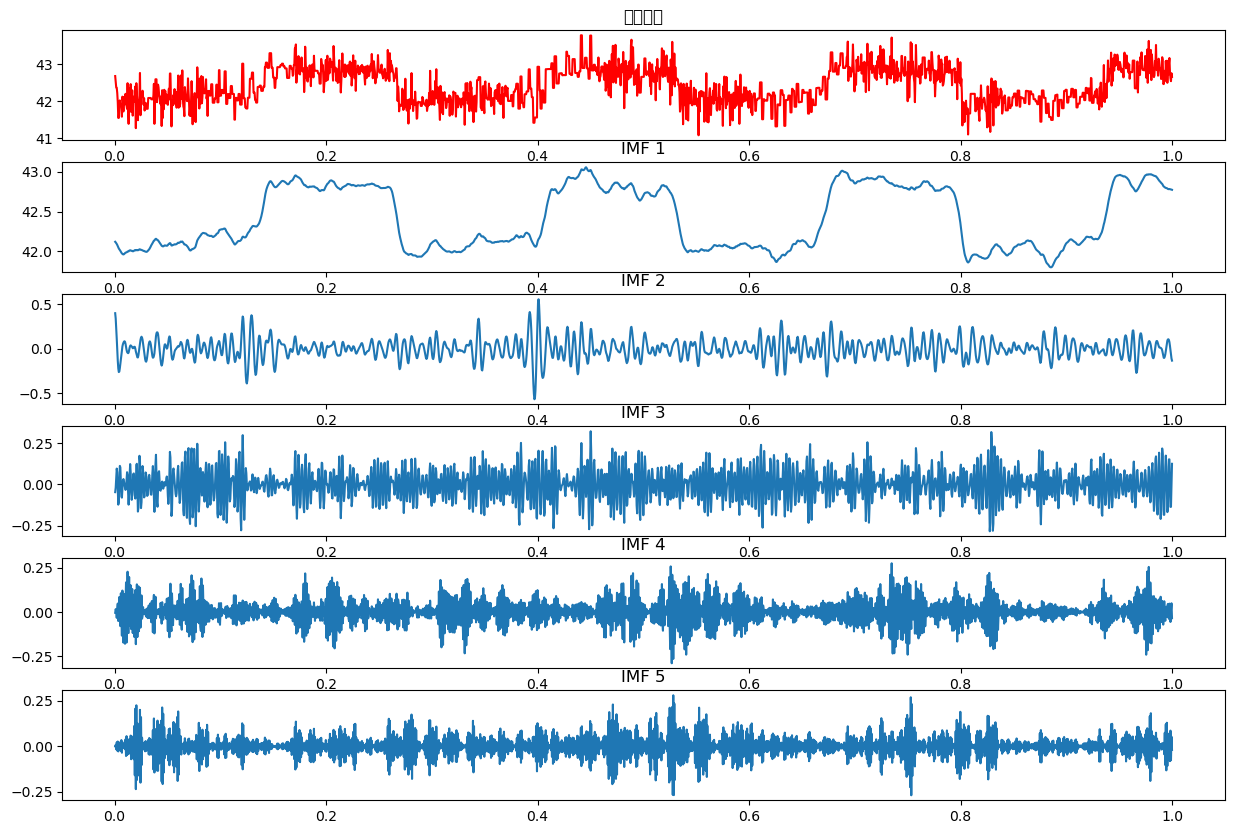

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from vmdpy import VMD   
  
# -----测试信号及其参数--start-------------
signal=X_train_first_12[0]
T = len(signal)
fs = 1/T
t = np.arange(1,T+1)/T
 
# alpha 惩罚系数；带宽限制经验取值为抽样点长度1.5-2.0倍.
# 惩罚系数越小，各IMF分量的带宽越大，过大的带宽会使得某些分量包含其他分量言号;
alpha = 1000
 
#噪声容限，一般取 0, 即允许重构后的信号与原始信号有差别。
tau = 0 
#模态数量  分解模态（IMF）个数
K = 5
 
#DC 合成信号若无常量，取值为 0；若含常量，则其取值为 1
# DC 若为0则让第一个IMF为直流分量/趋势向量
DC = 0 
#初始化ω值，当初始化为 1 时，均匀分布产生的随机数
# init 指每个IMF的中心频率进行初始化。当初始化为1时，进行均匀初始化。
init = 1 
#控制误差大小常量，决定精度与迭代次数
tol = 1e-7
# -----测试信号及其参数--end----------
 
# Apply VMD
# 输出U是各个IMF分量，u_hat是各IMF的频谱，omega为各IMF的中心频率
u, u_hat, omega= VMD(signal, alpha, tau, K, DC, init, tol)


## step2:显示IMF组和原始信号和重构信号；
- 每个IMF都代表了原始信号的某种固有振动模式信息；
- IMF包含的信息可通过筛选(评估IMF与原始信号的相关性)后，以达到去噪的效果；之后再重构；

In [ ]:
#得到中心频率的数值
print(omega[-1])
# Plot the original signal and decomposed modes
plt.figure(figsize=(15,10))
plt.subplot(K+1, 1, 1)
plt.plot(t, signal, 'r')
plt.title("原始信号")
for num in range(K):
    plt.subplot(K+1, 1, num+2)
    plt.plot(t, u[num,:])
    plt.title("IMF "+str(num+1))
 
plt.show()